In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import statsmodels.formula.api as smf
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [26]:
# Load in data
data = pd.read_csv('data/p4kreviews.csv', encoding='latin1', index_col=[0])

First, let's look at the structure of the data:

In [27]:
data.head()

,album,artist,best,date,genre,review,score
1,A.M./Being There,Wilco,1,December 6 2017,Rock,Best new reissue 1 / 2 Albums Newly reissued a...,7.0
2,No Shame,Hopsin,0,December 6 2017,Rap,"On his corrosive fifth album, the rapper takes...",3.5
3,Material Control,Glassjaw,0,December 6 2017,Rock,"On their first album in 15 years, the Long Isl...",6.6
4,Weighing of the Heart,Nabihah Iqbal,0,December 6 2017,Pop/R&B,"On her debut LP, British producer Nabihah Iqba...",7.7
5,The Visitor,Neil Young / Promise of the Real,0,December 5 2017,Rock,"While still pointedly political, Neil Youngs ...",6.7


# Overview
The online music magazine Pitchfork describes itself as "the most trusted voice in music". But how trustworthy is it really? Or, in other words, is the site biased? In this project we attempt to figure this out by examining these questions:
- How do reviews for genres change over time?
- Is there a correlation between a song's score and it being in Pitchfork's Best New Music?
- Is there a correlation between genre and review score?
- Is there a correlation between genre and selection for Best New Music?

The data we will use was retrieved from a database containing over 18,000 reviews from the online music magazine “Pitchfork”. This data was collected by Nolan Conaway and made publicly accessible via Kaggle.

# Data Prep
In this section, we will prep the data for easier analysis.

For later convenience, we can create a GroupBy object where all reviews by a particular artist are groupped together:

In [28]:
grouped_by_artist = data.groupby(['artist'])
grouped_by_artist

Looking at our dataset, we see that there are ~800 reviews for "Various Artists".  At the time of analysis of artist statistics, "Various Artists" doesn't provide much insight as we do not know the specific artist.  So, we can remove rows where the artist is "Various Artists".

In [29]:
reviews_no_various_artists = data[data.artist != "Various Artists"]

In [30]:
# Convert date column to date values
data['date'] = pd.to_datetime(data['date'])
reviews_no_various_artists['date'] = pd.to_datetime(reviews_no_various_artists['date'])

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


For convenience sake, it may be easier to visualize the score given to an album as being out of 100.  We multiply by 10 here.

In [31]:
data["score_of_100"] = pd.to_numeric(data["score"]*10, downcast='integer')
reviews_no_various_artists["score_of_100"] = pd.to_numeric(reviews_no_various_artists["score"]*10, downcast='integer')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Exploration
In this section, we will examine the data a little more closely.

Here we have calculated the mean score out of all reviews from the data. This gives us a basic understanding of how high/low Pitchfork reviewers score. The average score of all reviews is 7.027.

In [32]:
# Calculate the mean score for all reviews -- including "Various Artists"
mean_score = np.mean(data["score"])
print(mean_score)

7.027445666069992


To further examine the scores Pitchfork reviewers give, we have broken down the average scores by genre. This not only gives us a baseline for scores of the various genres but also gives us a preliminary examination of the reviewers' preferences. Based solely on the average review score, Jazz music recieves the highest scores (average of 7.568) and Electronic music recieves the lowest scores (average of 6.941). Keep in mind, this table shows solely averages so it does not factor in how many reviews are in each genre.

In [33]:
# Calculate the average scores for each genre.  
groupped_by_genre = data.groupby(by="genre").agg(np.mean)
groupped_by_genre['score']

genre
Electronic      6.941318
Experimental    7.359035
Folk/Country    7.219857
Global          7.434831
Jazz            7.568482
Metal           6.980410
None            7.020611
Pop/R&B         6.948315
Rap             6.950304
Rock            6.983616
Name: score, dtype: float64

Although we can compare averages between genres, the amount of reviews per genre could greatly skew these average scores. Because of this, we have chosen to also examine the number of reviews for each genre. So, although jazz has the highest average score, there are only 257 reviews. This is extremely low compared to some of the other genres, such as Rock which has 6958 reviews.

In [34]:
# number of reviews in genre
review_count = data.groupby('genre').size().reset_index(name='count')
review_count

,genre,count
0,Electronic,4020
1,Experimental,1699
2,Folk/Country,700
3,Global,178
4,Jazz,257
5,Metal,781
6,None,2324
7,Pop/R&B,1157
8,Rap,1481
9,Rock,6958


Here, we show the ratios of the amount of reviews that are in best new music compared to total reviews, broken down by genre. In other words, for each genre, we have calculated the percentage of reviews that were chosen for Best New Music. We see that Jazz has the highest percentage (9.727%) and no genre has the worst percentage (2.367%).

In [35]:
# Find ratios of best new music to number of reviews in genre
best_new_music = data[data["best"] == 1]
best_new_music_by_genre = data.groupby(['genre']).agg(['mean']) # 'Best' is either 1 or 0, so we can just average the best column
bnm_ratios = best_new_music_by_genre['best']
bnm_ratios

,mean
genre,
Electronic,0.048010
Experimental,0.065333
Folk/Country,0.047143
Global,0.050562
Jazz,0.097276
Metal,0.028169
None,0.023666
Pop/R&B,0.075194
Rap,0.055368


## Number of Reviews Per Year
As part of our exploration, we wanted to find out how many reviews Pitchfork releases per year. We did this to get a sense of the volume of reviews that are put out per year, and explore if the volume of reviews is inconsistent over time. After performing this visualization, we found that from 1999 to 2003, Pitchfork experienced growth in the number of reviews released per year. From 2004 onward, the number of reviews released by Pitchfork remains relatively constant. From this, we have a better understanding of the growth of the magazine. Also, understanding the volume of transactions can help us understand potential discrepancies when we look at data broken down by year since earlier years have a smaller volume of reviews comparative to later years.

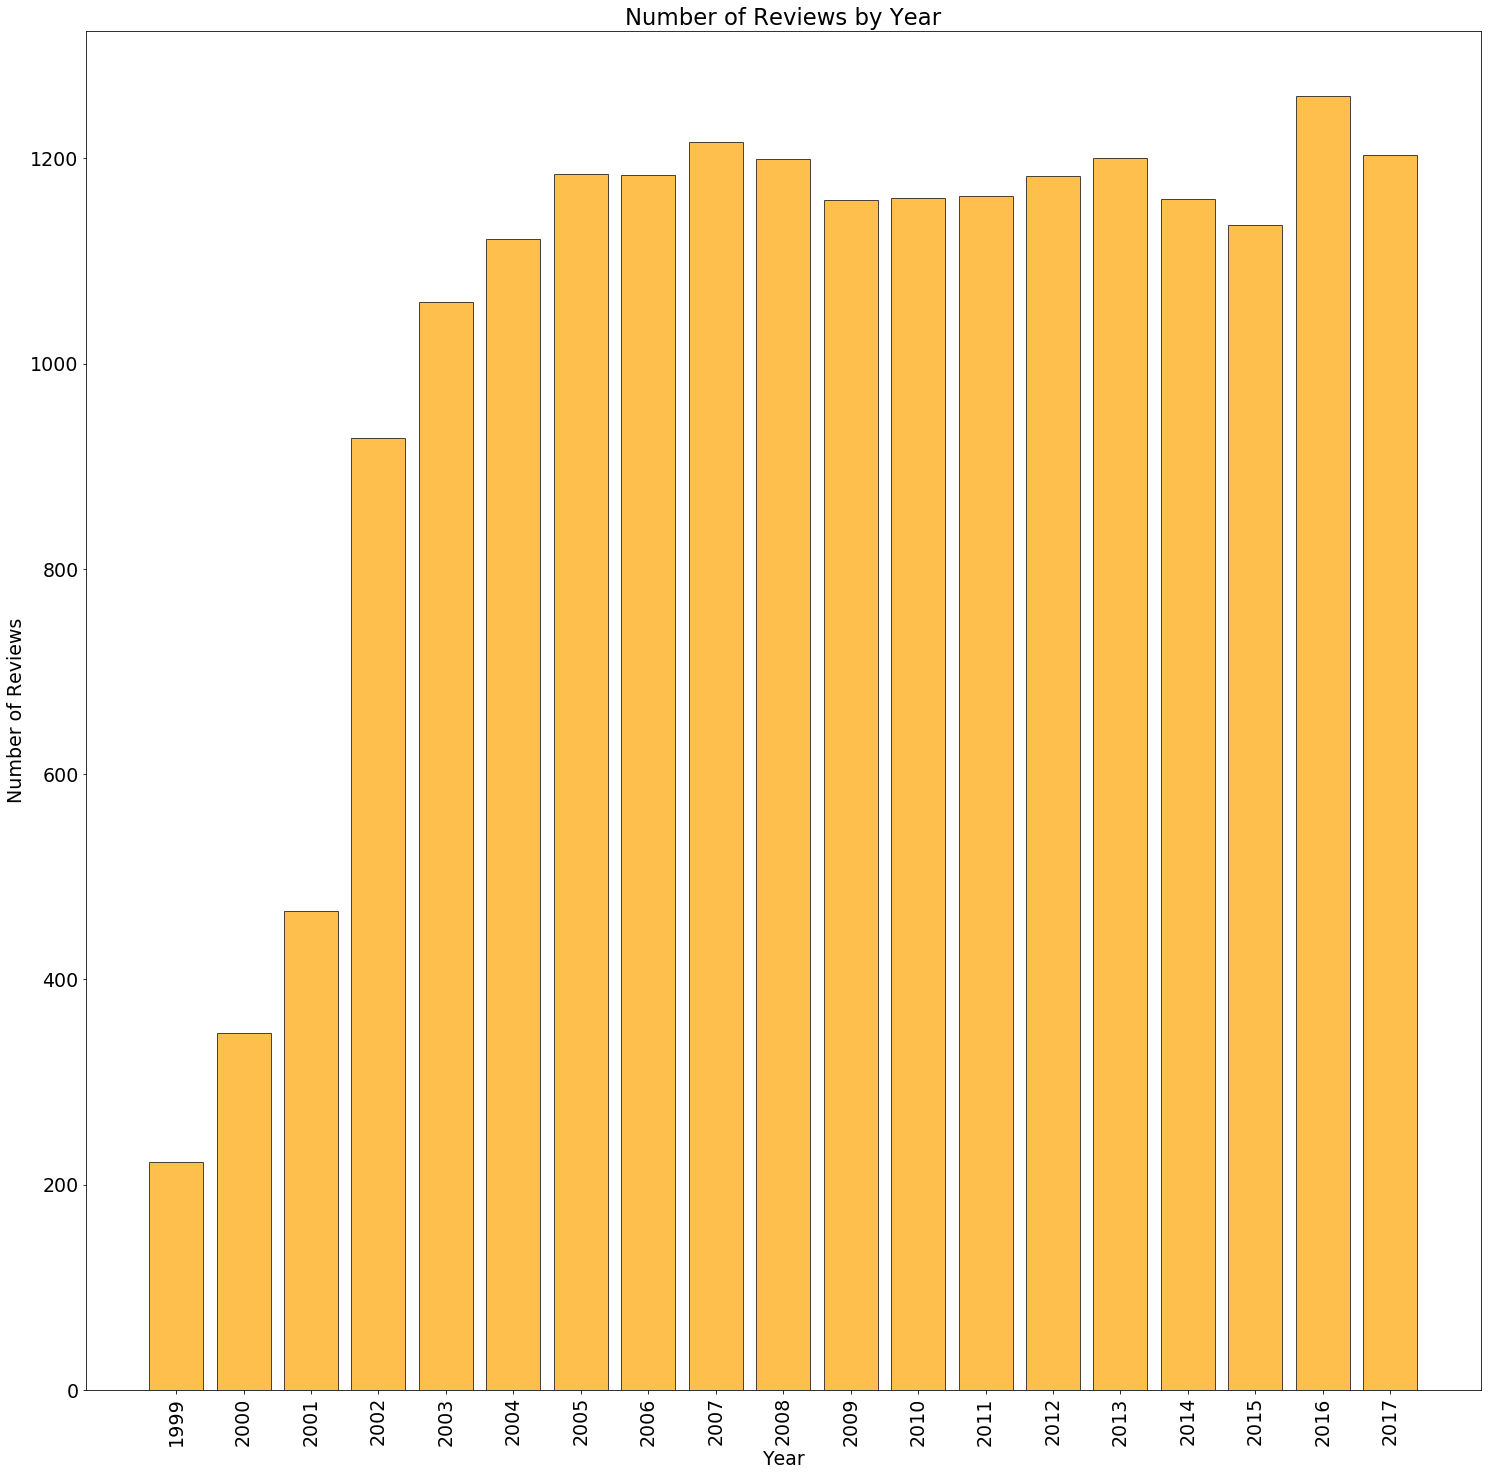

In [36]:
# num reviews per year
reviews_by_year = data[['review']].groupby(data['date'].dt.year).count()
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.bar(reviews_by_year.index, reviews_by_year['review'], color='orange', alpha=0.7, edgecolor='black')
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(x_labels)
plt.title("Number of Reviews by Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

## Number of Reviews Per Genre
As part of our initial exploration, we also wanted to explore the number of reviews per genre. We chose to perform this exploration because we wanted to know if there one genre that Pitchform tended to review over others because this could indicate a preference, which could potentially indicate a bias. From this exploration, we found that Pitchfork tends to review Rock music more than any other genre, having more ~3000 more reviews than the next most reviewed genre. This indicates that the magazine potentially has a preference of this music genre, which could lead to a bias in their reviews of Rock music.

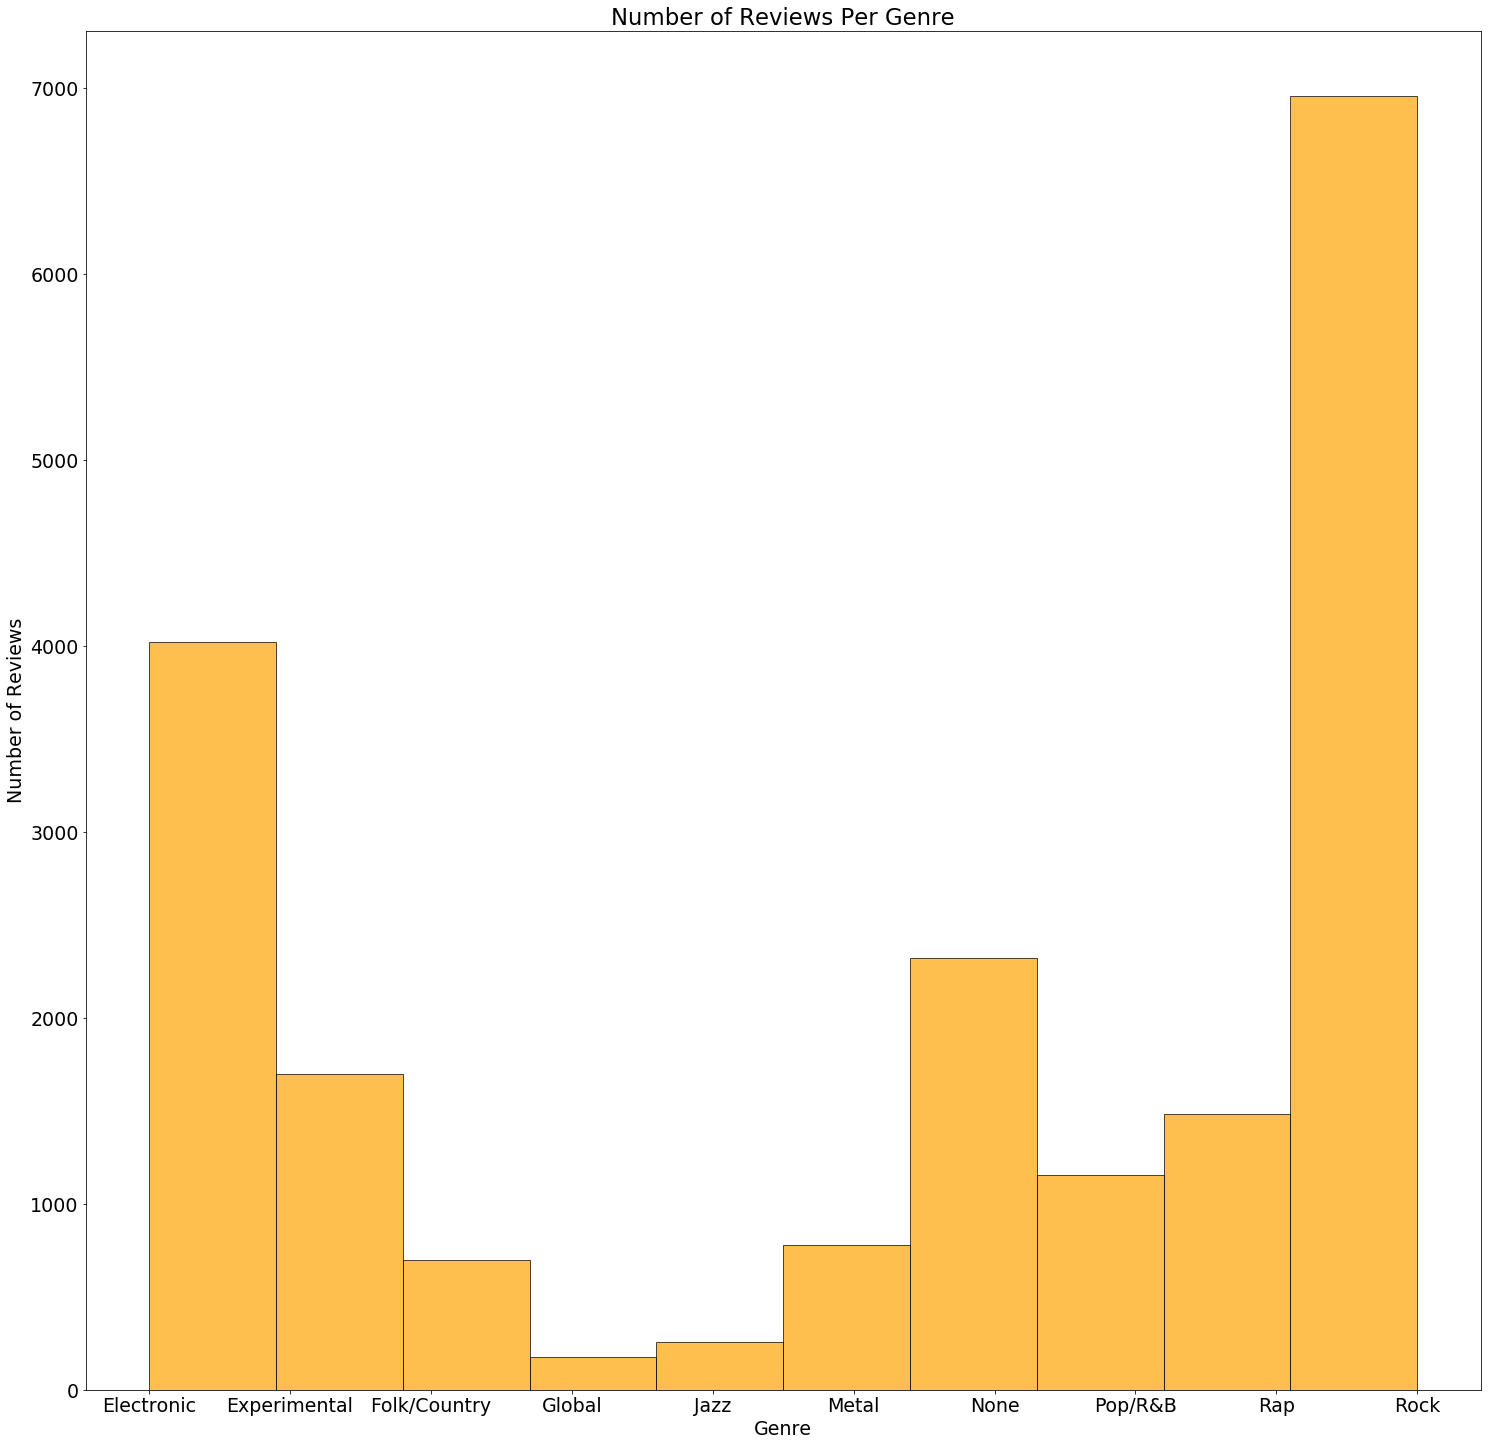

In [37]:
# number of reviews per genre
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(data['genre'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Number of Reviews Per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Reviews")
plt.show()

## Distribution of Scores
The next step we took in our initial exploration was to understand the distribution of scores. We thought this would be a useful exploration so we would have a better understanding of what the most common review score is. Since review scores can contain decimals (ex: 7.6/10), we decided to make our scores out of 100 in order to gain a more in-depth understanding of the distribution of scores. From this exploration, we see a right-shift in our data. This shows us that Pitchfork is more likely to give a higher score than a lower scores. We also see that the data peaks around the 70s, so we can see that most reviews are about 7 points out of 10.

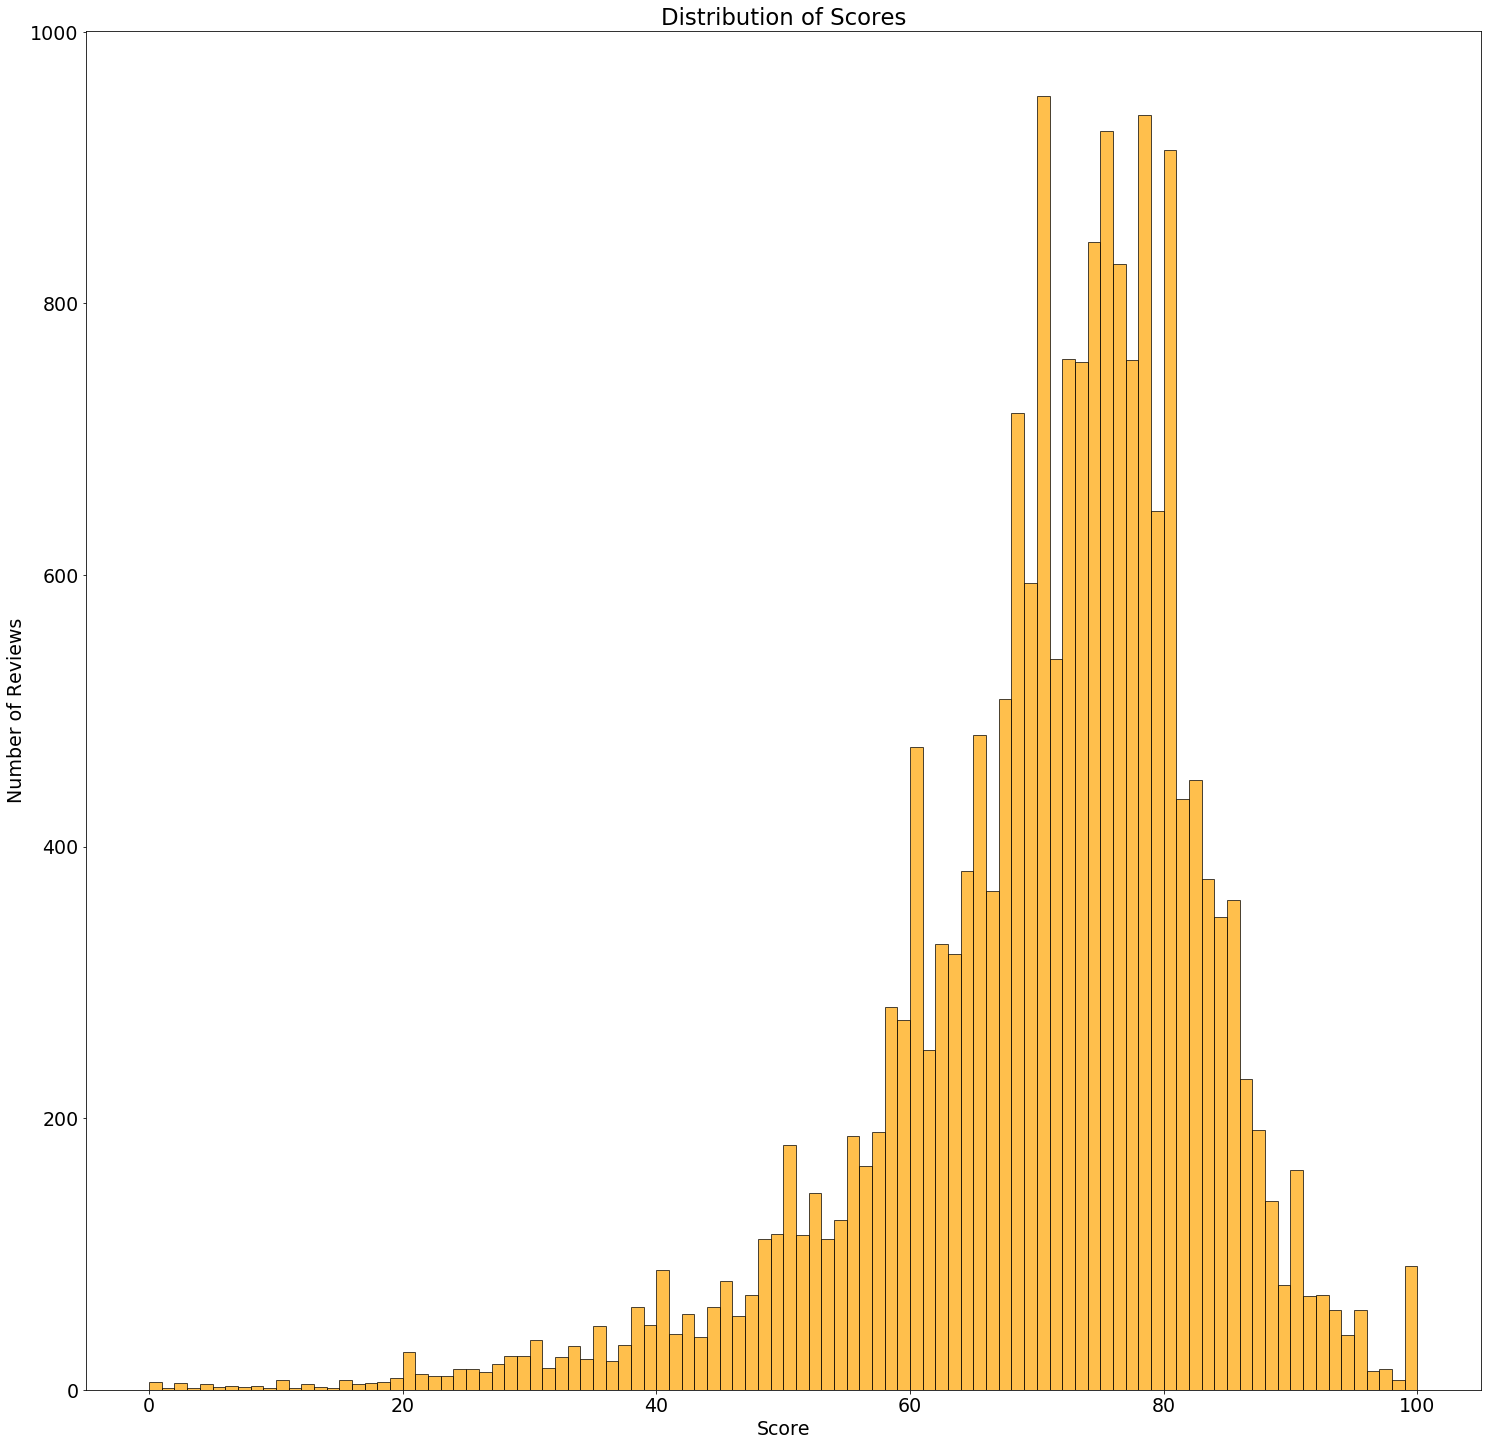

In [38]:
# Distribution of scores
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(data['score_of_100'], bins=100, color='orange', alpha=0.7, edgecolor='black')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.show()

## Word Count
Something we thought could be interesting to explore would be the word counts from reviews. We were thinking about exploring review word count in relation to review scores and genre to see if there is a correlation between these factors, and felt that a good first step to take before performing any type of regression would be to understand common 

In [23]:
# Count the words in the reviews -- takes a long time
count_array = []
for i in data.index:
    count = len(nltk.word_tokenize(str(data["review"][i])))
    count_array.append(count)
data["review_word_count"] = count_array

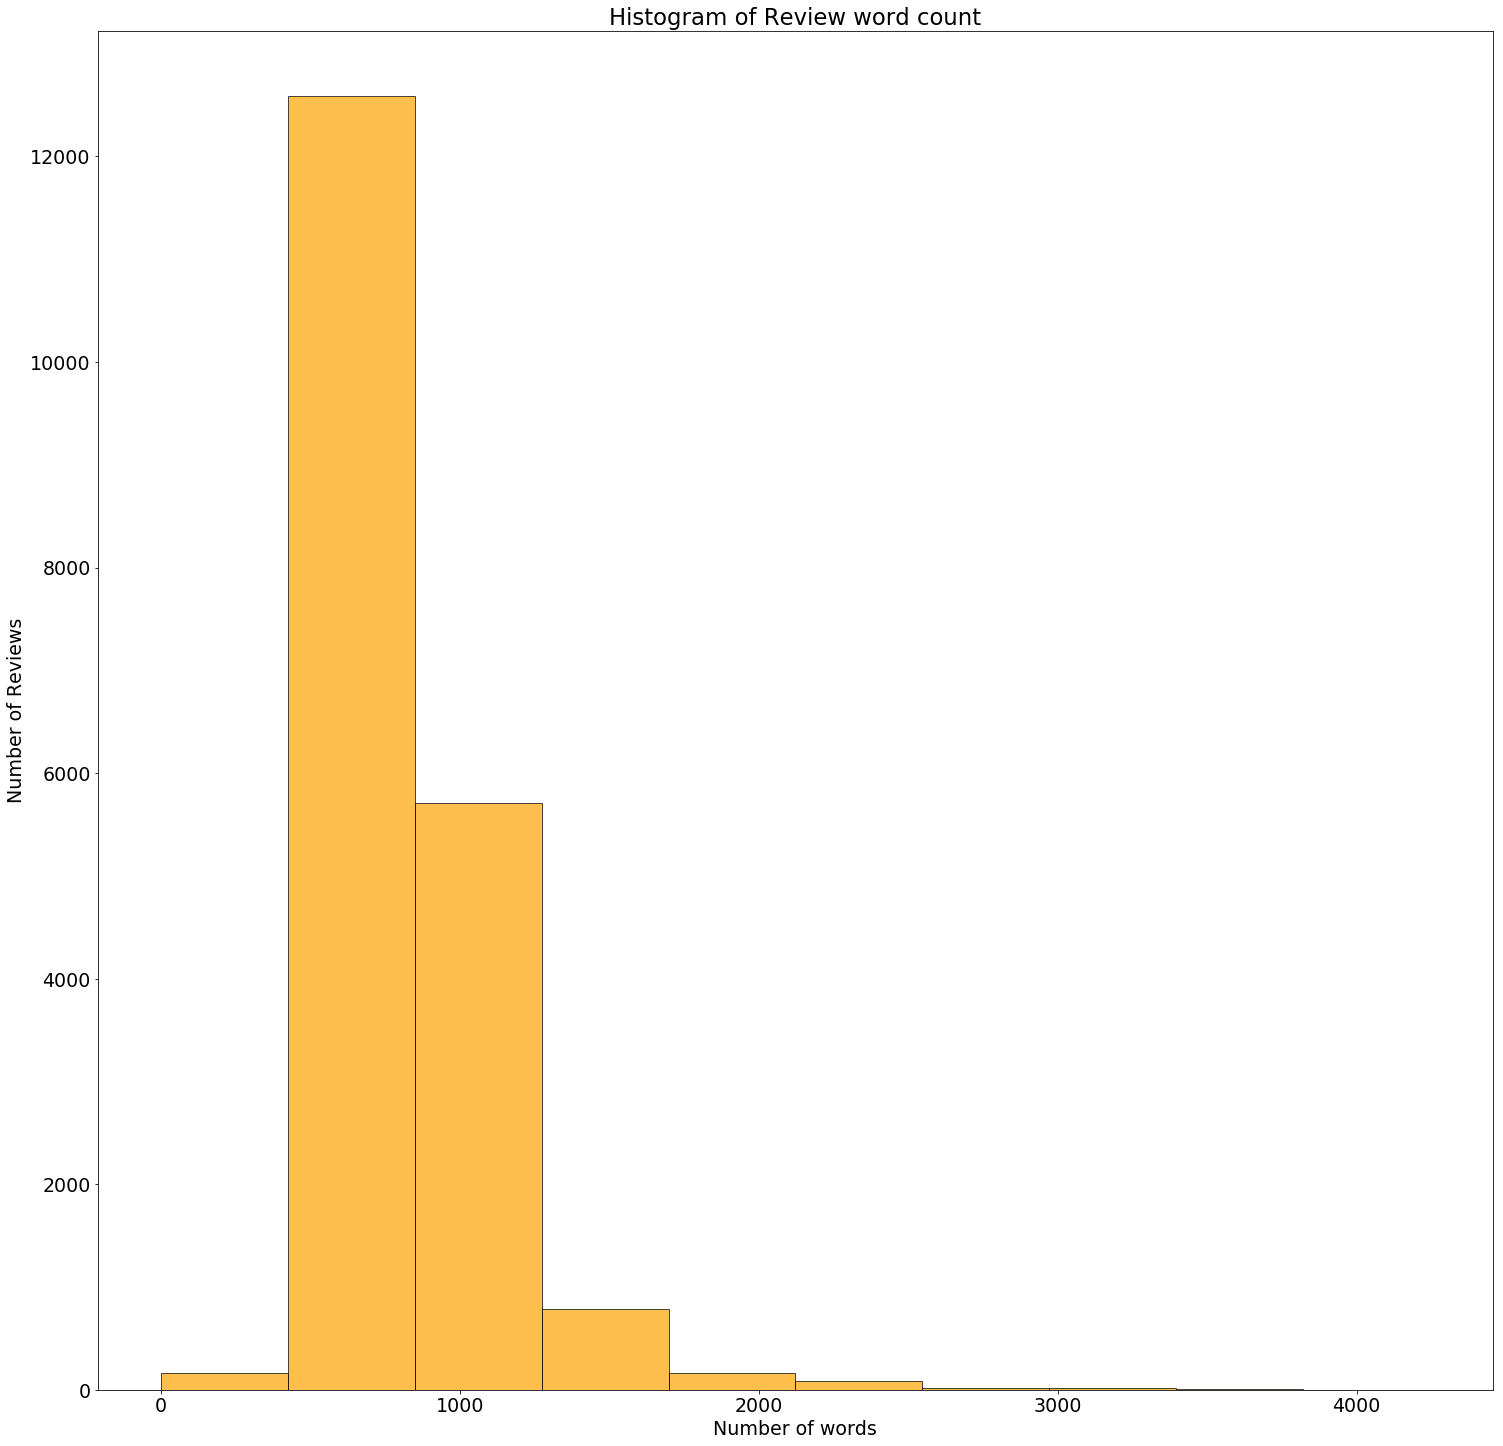

In [24]:
# Distribution of word count for reviews
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(data['review_word_count'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Histogram of Review word count")
plt.xlabel("Number of words")
plt.ylabel("Number of Reviews")
plt.show()

In [ ]:
# Average score for each genre
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.bar(groupped_by_genre.index, groupped_by_genre['score'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Average score by genre")
plt.xlabel("Score")
plt.ylabel("Genre")
plt.show()

In [ ]:
genres = data.loc[data['genre'] == 'Rock']
genres = genres.groupby(data['date'].dt.year).aggregate('mean')

In [ ]:
# Mean score by genre by year
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
for genre in data['genre'].unique():
    if genre != 'None':
        genres = data.loc[data['genre'] == genre]
        genres = genres.groupby(data['date'].dt.year).aggregate('mean')
        ax.scatter(genres.index, genres['score'], label=None)
        ax.plot(genres.index, genres['score'], label=genre)
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(x_labels)
plt.title("Mean Score By Genre By Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
# Number of albums per genre over time
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
for genre in data['genre'].unique():
    if genre != 'None':
        genres = data.loc[data['genre'] == genre]
        genres = genres.groupby(data['date'].dt.year).aggregate('count')
        ax.scatter(genres.index, genres['score'], label=None)
        ax.plot(genres.index, genres['score'], label=genre)
    
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(x_labels)
plt.title("Number of Reviews by Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()
plt.rcParams.update({'font.size': 15})
plt.show()

In [ ]:
# Selects a random sample of reviews for artists (excluding "Various Artists")
sample = reviews_no_various_artists.sample(n=10, random_state=0)
plt.figure(figsize=(25, 10))
sns.stripplot(x=sample['artist'], y=sample['score'], jitter=True)
plt.show()

# Analysis

In [19]:
#Let's see if we can find any statistically significant relationships using linear modeling
mod = smf.ols(formula= 'best ~ score + genre', data=data)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   best   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     213.1
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:05:33   Log-Likelihood:                 2486.1
No. Observations:               19555   AIC:                            -4950.
Df Residuals:                   19544   BIC:                            -4864.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3278      0.009    -36.488      0.000      -0.345      -0.310
genre[T.Experimental]    -0.0053      0.006     -0.855      0.392      -0.017       0.007
genre[T.Folk/Country]    -0.0159      0.009     -1.826      0.068      -0.033       0.001
genre[T.Global]          -0.0242      0.016     -1.479      0.139      -0.056       0.008
genre[T.Jazz]             0.0153      0.014      1.115      0.265      -0.012       0.042
genre[T.Metal]           -0.0220      0.008     -2.634      0.008      -0.038      -0.006
genre[T.None]            -0.0286      0.006     -5.155      0.000      -0.040      -0.018
genre[T.Pop/R&B]          0.0268      0.007      3.770      0.000       0.013       0.041
genre[T.Rap]              0.0069      0.006      1.061      0.289      -0.006       0.020
genre[T.Rock]             0.0105      0.004      2.485      0.013       0.002       0.019
score                     0.0541      0.001     45.109      0.000       0.052       0.056
==============================================================================
Omnibus:                    13456.538   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133561.087
Skew:                           3.396   Prob(JB):                         0.00
Kurtosis:                      13.854   Cond. No.                         78.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
top_100_artists = reviews_no_various_artists.groupby(['artist']).size().sort_values(ascending=False)
top_100_artists = top_100_artists.head(n=100)
top_100_artists

artist
Guided by Voices                                25
David Bowie                                     22
The Beatles                                     21
Mogwai                                          21
Of Montreal                                     20
The Fall                                        20
Animal Collective                               19
Neil Young                                      19
Robert Pollard                                  19
Bob Dylan                                       18
Xiu Xiu                                         18
R.E.M.                                          17
Sonic Youth                                     16
Gucci Mane                                      16
Four Tet                                        16
Bonnie Prince Billy                           16
Deerhoof                                        16
Lil Wayne                                       15
The Flaming Lips                                15
Nine Inch Nails         

In [82]:
artist_score = pd.DataFrame(columns=['artist', 'avg_score', 'best_score', 'std'])
for artist, count in top_100_artists.items():
    artist_reviews = data[data['artist'] == artist]
    avg_score = artist_reviews['score'].mean()
    best_score = artist_reviews['score'].max()
    worst_score = artist_reviews['score'].min()
    std = artist_reviews['score'].std()
    artist_score = artist_score.append({'artist': artist, 'avg_score': avg_score, 'best_score': best_score, 'worst_score': worst_score,'std': std}, ignore_index=True)

artist_score = artist_score.sort_values(by=["avg_score"], ascending = False)
artist_score

,artist,avg_score,best_score,std,worst_score
2,The Beatles,8.890476,10.0,1.314117,6.0
35,Miles Davis,8.730769,9.5,0.833051,6.6
64,Califone,8.308333,9.2,0.462126,7.3
25,Radiohead,8.071429,10.0,1.930496,4.0
61,Tim Hecker,8.066667,8.7,0.539921,6.8
55,William Basinski,8.041667,10.0,0.954852,7.0
36,Saint Etienne,8.015385,9.0,0.757018,6.4
44,Mouse on Mars,7.950000,9.6,0.783349,7.0
11,R.E.M.,7.947059,10.0,1.603947,5.0
56,Arthur Russell,7.883333,8.9,0.676667,6.5
